<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-Tensorflow/blob/master/ch4/ch4_nb4_apply_transfer_learning.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 4: Influential Classification Tools</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 4:</small><br/>Applying Transfer Learning</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In this last notebook covering Chapter 4, we will demonstrate how transfer learning can be achieved with Keras. More precisely, we will present how Keras Applications pre-trained on rich datasets can be reused for new tasks. Unlike Notebook <a href="./ch4_notebook_3_resnet_from_keras_app.ipynb">4-3</a> where we instantiated a <em>ResNet-50</em> from Keras-App with random parameters, we will this time ask Keras to fetch for us the parameters pre-trained on ImageNet.
    <br/><br/>
    This will give us the opportunity to test different types of transfer learning; i.e. <strong><em>freezing</strong></em> or <strong><em>fine-tuning</strong></em> the feature-extractor layers.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math

# Some hyper-parameters:
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 300           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

## Preparing the Data

Again, to directly compare with the results from the [previous notebooks](./ch4_nb1_implement_resnet_from_scratch.ipynb), we will apply our model to the classification of the benchmark dataset_CIFAR-100_, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton[$^1$](#ref).

We will reuse the input pipelines previously defined:

In [ ]:
# !pip install tensorflow-datasets # Uncomment to install the module

In [2]:
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes:
num_classes = cifar_info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

input_shape = [224, 224, 3]

tfds.core.DatasetInfo(
    name='cifar100',
    version=1.3.1,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100)
    },
    total_num_examples=60000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=50000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @TECHREPORT{Krizhevsky09learning

In [9]:
train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=input_shape, seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(
    phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
    input_shape=input_shape, seed=random_seed)

## Freezing the ResNet Feature Extractor

In this first part, we will use the _ResNet-50_ network[$^2$](#ref) from Keras Application, pre-trained on _ImageNet_[$^3$](#ref), as a feature extractor, and build a new classifier for _CIFAR_ on top (c.f. Chapter 4). We will then illustrate the first transfer learning use-case presented in the book, i.e., completely freezing the feature extractor and only training the new dense layers on top.

### Building a New Classifier from Pre-trained Keras Applications

We first build our model, a _ResNet-50_ solution to predict from the 100 classes of _CIFAR-100_.

To do so, we first use Keras Applications to instantiate a network with pre-trained weights, but without any top layers (i.e., without the final dense layers leading to predictions):

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=input_shape)
# resnet50_feature_extractor.summary()

/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


As mentioned earler, we then _freeze_ this feature extractor; i.e., we make the layers of this network non-trainable, as we want to preserve the knowledge this ResNet obtained by being trained on ImageNet, a much richer dataset.

However, while we want to preserve the feature-extracting layers (i.e., the convolutional layers making most of ResNet), **we should be careful not to freeze some other layers like the regularization ones**. Layers like the _batch-normalization_ ones (added after most of the convolutions in *ResNet* architectures) have some trainable parameters (c.f. Chapter 3) which tend to become too dataset-specific. It is often recommended not to freeze such layers and let them adapt to the new task/dataset. Therefore, we check the layers' type before freezing them or not:

In [4]:
frozen_layers, trainable_layers = [], []
for layer in resnet50_feature_extractor.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False
        frozen_layers.append(layer.name)
    else:
        if len(layer.trainable_weights) > 0:
            # We list as "trainable" only the layers with trainable parameters.
            trainable_layers.append(layer.name)

In [5]:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

# Logging the lists of frozen/trainable layers:
print("{2}Layers we froze:{4} {0} ({3}total = {1}{4}).".format(
    frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))
print("\n{2}Layers which will be fine-tuned:{4} {0} ({3}total = {1}{4}).".format(
    trainable_layers, len(trainable_layers), log_begin_blue, log_begin_bold, log_end_format))

Layers we froze: ['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c', 'res3a_branch2a', 'res3a_branch2b', 'res3a_branch2c', 'res3a_branch1', 'res3b_branch2a', 'res3b_branch2b', 'res3b_branch2c', 'res3c_branch2a', 'res3c_branch2b', 'res3c_branch2c', 'res3d_branch2a', 'res3d_branch2b', 'res3d_branch2c', 'res4a_branch2a', 'res4a_branch2b', 'res4a_branch2c', 'res4a_branch1', 'res4b_branch2a', 'res4b_branch2b', 'res4b_branch2c', 'res4c_branch2a', 'res4c_branch2b', 'res4c_branch2c', 'res4d_branch2a', 'res4d_branch2b', 'res4d_branch2c', 'res4e_branch2a', 'res4e_branch2b', 'res4e_branch2c', 'res4f_branch2a', 'res4f_branch2b', 'res4f_branch2c', 'res5a_branch2a', 'res5a_branch2b', 'res5a_branch2c', 'res5a_branch1', 'res5b_branch2a', 'res5b_branch2b', 'res5b_branch2c', 'res5c_branch2a', 'res5c_branch2b', 'res5c_branch2c'] (total = 53).


Layers which will be fine

We now add on top of this network the trainable layers to make predictions from the features:

In [6]:
features = resnet50_feature_extractor.output
avg_pool = GlobalAveragePooling2D(data_format='channels_last')(features)
predictions = Dense(num_classes, activation='softmax')(avg_pool)

resnet50_freeze = Model(resnet50_feature_extractor.input, predictions)

### Training the Network

Similarly, the training script itself is purely copy-pasted from previous notebooks (we invite our readers to check them if details are needed). Indeed, with the loading of the pre-trained weights and the freezing of the desired layers already covered, the resulting model can be trained like any others:

In [10]:
import collections
import functools
from keras_custom_callbacks import SimpleLogCallback

metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")])

model_dir = './models/resnet_keras_app_freeze_all'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5)
]

# Compile:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)
resnet50_freeze.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
    ])

# Train:
history_freeze = resnet50_freeze.fit(
    train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 3.091; v-loss = 1.981; acc = 0.289; v-acc = 0.492; top5-acc = 0.559; v-top5-acc = 0.790
Epoch  1/300: loss = 1.904; v-loss = 1.502; acc = 0.504; v-acc = 0.587; top5-acc = 0.802; v-top5-acc = 0.861
Epoch  2/300: loss = 1.562; v-loss = 1.306; acc = 0.575; v-acc = 0.627; top5-acc = 0.855; v-top5-acc = 0.890
Epoch  3/300: loss = 1.377; v-loss = 1.182; acc = 0.618; v-acc = 0.658; top5-acc = 0.880; v-top5-acc = 0.907
Epoch  4/300: loss = 1.257; v-loss = 1.118; acc = 0.646; v-acc = 0.674; top5-acc = 0.898; v-top5-acc = 0.917
Epoch  5/300: loss = 1.183; v-loss = 1.070; acc = 0.665; v-acc = 0.683; top5-acc = 0.908; v-top5-acc = 0.921
Epoch  6/300: loss = 1.114; v-loss = 1.029; acc = 0.681; v-acc = 0.699; top5-acc = 0.920; v-top5-acc = 0.923
Epoch  7/300: loss = 1.067; v-loss = 0.995; acc = 0.693; v-acc = 0.707; top5-acc = 0.923; v-top5-acc = 0.930
Epoch  8/300: loss = 1.019; v-loss = 0.966; acc = 0.706; v-acc = 0.714; top5-acc = 0.929; v-top5-acc = 0.935
Ep

Epoch 39/300: loss = 0.580; v-loss = 0.778; acc = 0.825; v-acc = 0.771; top5-acc = 0.974; v-top5-acc = 0.955
Epoch 40/300: loss = 0.574; v-loss = 0.777; acc = 0.827; v-acc = 0.771; top5-acc = 0.975; v-top5-acc = 0.956
Epoch 41/300: loss = 0.561; v-loss = 0.779; acc = 0.831; v-acc = 0.768; top5-acc = 0.975; v-top5-acc = 0.954
Epoch 42/300: loss = 0.559; v-loss = 0.775; acc = 0.832; v-acc = 0.774; top5-acc = 0.976; v-top5-acc = 0.954
Epoch 43/300: loss = 0.552; v-loss = 0.774; acc = 0.833; v-acc = 0.772; top5-acc = 0.977; v-top5-acc = 0.955
Epoch 44/300: loss = 0.546; v-loss = 0.774; acc = 0.836; v-acc = 0.771; top5-acc = 0.977; v-top5-acc = 0.954
Epoch 45/300: loss = 0.539; v-loss = 0.768; acc = 0.836; v-acc = 0.774; top5-acc = 0.978; v-top5-acc = 0.957
Epoch 46/300: loss = 0.541; v-loss = 0.767; acc = 0.837; v-acc = 0.775; top5-acc = 0.977; v-top5-acc = 0.956
Epoch 47/300: loss = 0.530; v-loss = 0.775; acc = 0.840; v-acc = 0.773; top5-acc = 0.978; v-top5-acc = 0.957
Epoch 48/300: loss 

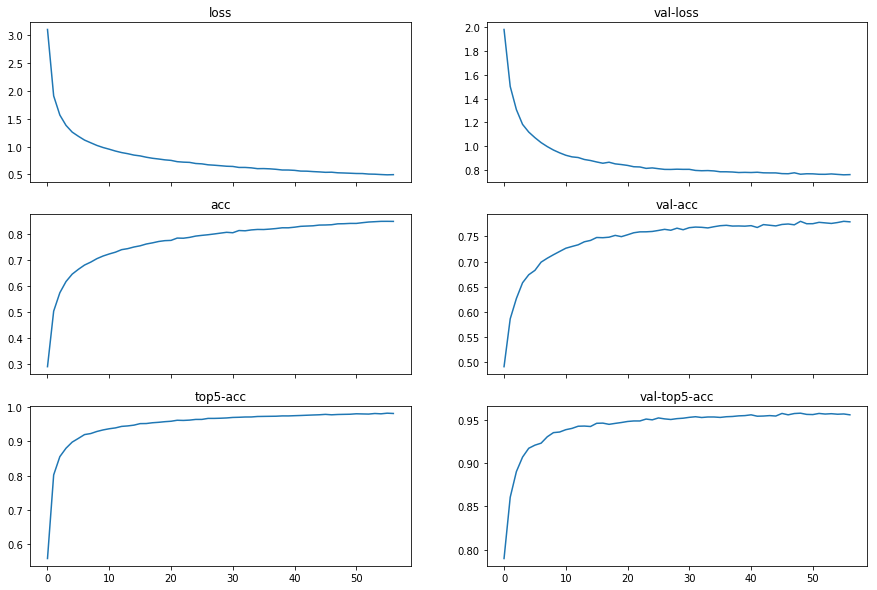

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history_freeze.history['loss'])
ax[0, 1].plot(history_freeze.history['val_loss'])
ax[1, 0].plot(history_freeze.history['acc'])
ax[1, 1].plot(history_freeze.history['val_acc'])
ax[2, 0].plot(history_freeze.history['top5_acc'])
ax[2, 1].plot(history_freeze.history['val_top5_acc'])

Carefully freezing the feature extractor, we achieved a new high in terms of accuracy! With ~78% top-1 / ~95% top-5 accuracy, we are now quite far from the original ~65% top-1 / ~88% top-5 accuracy obtained with the same model, without transfer learning.

## Fine-tuning the ResNet Feature Extractor

In the following section, we will define the exact same ResNet-50 network with pre-trained layers. However this time, we will not completely freeze its feature-extractor component, in order to _fine-tune_ the latest, higher-level convolutional layers. As we explained in Chapter 4, this fine-tuning can benefit the new classifier which may learn to extract more task-relevant features _(fine-tuning is recommend only if the training dataset is big enough to avoid over-fitting)_.

### Selectively Freezing Layers

The idea this time is to fix the weights of some of the first layers, and retrain all the others. For instance, the code below demonstrates how we could fix the weights of the 3 first _macro-blocks_ only (see Notebook [4-1](./ch4_nb1_implement_resnet_from_scratch.ipynb) for definition of "_macro-block_") and fine-tune the remaining one while training the new final layers.

In [14]:
for layer in resnet50_feature_extractor.layers:
    if 'res5' in layer.name:
        # Keras developers named the layers in their ResNet implementation to explicitly 
        # identify which macro-block and block each layer belongs to.
        # If we reach a layer which has a name starting by 'resnet5', it means we reached 
        # the 4th macro-block / we are done with the 3rd one (see layer names listed previously):
        break
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False

### Meta-Iterating to Find the Best Transfer Learning Solution

Note that in practice, **deciding which layers to fine-tune or not may require several trainings** to compare the performance of the corresponding models. This is what we will try in this section.

We will test different macro-configurations, freezing a variable number of layers and evaluating the performance of the resulting network during training. In this example, we will try freezing from 0 to all the four macro-blocks of the ResNet feature-extractor.

_Warning_: these 4 consecutive trainings may take days. In practice, it would be recommended for instance to run them in parallel. Note that thanks to the `ModelCheckpoint()` callback, it is however possible to restore models if the trainings are interrupted (adding the line `resnet50_finetune.load_weights(filename_latest_checkpoint)` before launching the training again. Note also that we are turning off the Keras logs this time, to keep the notebook readable.

In [16]:
num_macroblocks_to_freeze = [0, 1, 2, 3] # we already covered the "all 4 frozen" case above.

histories = dict()
histories['freeze all'] = history_freeze
for freeze_num in num_macroblocks_to_freeze:
        
    print("{1}{2}>> {3}ResNet-50 with {0} macro-block(s) frozen{4}:".format(
        freeze_num, log_begin_green, log_begin_bold, log_begin_underline, log_end_format))
    
    # ---------------------
    # 1. We instantiate a new classifier each time:
    resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(
        include_top=False, weights='imagenet', 
        input_shape=input_shape, classes=num_classes)

    features = resnet50_feature_extractor.output
    avg_pool = GlobalAveragePooling2D(data_format='channels_last')(features)
    predictions = Dense(num_classes, activation='softmax')(avg_pool)

    resnet50_finetune = Model(resnet50_feature_extractor.input, predictions)
    
    # ---------------------
    # 2. We freeze the desired layers: 
    break_layer_name = 'res{}'.format(freeze_num + 2) if freeze_num > 0 else 'conv1'
    frozen_layers = []
    for layer in resnet50_finetune.layers:
        if break_layer_name in layer.name:
            break
        if isinstance(layer, tf.keras.layers.Conv2D):
            # If the layer is a convolution, and isn't after the 1st layer not to train:
            layer.trainable = False
            frozen_layers.append(layer.name)
    
    print("\t> {2}Layers we froze:{4} {0} ({3}total = {1}{4}).".format(
        frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))
    
    # ---------------------
    # 3. To start from the beginning the data iteration, 
    #    we re-instantiate the input pipelines (same parameters):
    train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=input_shape, seed=random_seed)

    val_cifar_dataset = cifar_utils.get_dataset(
        phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
        input_shape=input_shape, seed=random_seed)

    # ---------------------
    # 4. We set up the training operations, and start the process:
    # We set a smaller learning rate for the fine-tuning:
    # optimizer = tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

    model_dir = './models/resnet_keras_app_freeze_{}_mb'.format(freeze_num)
    callbacks = [
        # Callback to interrupt the training if the validation loss/metrics converged:
        # (we use a shorter patience here, just to shorten a bit the demonstration, already quite long...)
        tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc', restore_best_weights=True),
        # Callback to log the graph, losses and metrics into TensorBoard:
        tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
        # Callback to save the model (e.g., every 5 epochs)::
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5)
    ]
    
    # Compile:
    resnet50_finetune.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
        ])

    # Train:
    print("\t> Training - {0}start{1} (logs = off)".format(log_begin_red, log_end_format))
    history = resnet50_finetune.fit(
        train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
        validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
        verbose=0, callbacks=callbacks)
    print("\t> Training - {0}over{1}".format(log_begin_green, log_end_format))

    acc = history.history['acc'][-1] * 100
    top5 = history.history['top5_acc'][-1] * 100
    val_acc = history.history['val_acc'][-1] * 100
    val_top5 = history.history['val_top5_acc'][-1] * 100
    epochs = len(history.history['val_loss'])
    print("\t> Results after {5}{0}{6} epochs:\t{5}acc = {1:.2f}%; top5 = {2:.2f}%; val_acc = {3:.2f}%; val_top5 = {4:.2f}%{6}".format(
        epochs, acc, top5, val_acc, val_top5, log_begin_bold, log_end_format))

    histories['freeze {}'.format(freeze_num)] = history

>> ResNet-50 with 0 macro-block(s) frozen:
	> Layers we froze: [] (total = 0).
	> Training - start (logs = off)
	> Training - over
	> Results after 20 epochs:	acc = 97.97%; top5 = 99.94%; val_acc = 80.15%; val_top5 = 95.91%
>> ResNet-50 with 1 macro-block(s) frozen:
	> Layers we froze: ['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c'] (total = 11).
	> Training - start (logs = off)
	> Training - over
	> Results after 29 epochs:	acc = 98.88%; top5 = 99.97%; val_acc = 81.91%; val_top5 = 96.08%
>> ResNet-50 with 2 macro-block(s) frozen:
	> Layers we froze: ['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c', 'res3a_branch2a', 'res3a_branch2b', 'res3a_branch2c', 'res3a_branch1', 'res3b_branch2a', 'res3b_branch2b', 'res3b

Once again (c.f. previous notebooks), the callbacks we defined allow us to follow the trainings in Tensorboard:

![Tensorboard Screenshot](./notebook_images/resnet_keras_app_transfer_learning_training.png)

Once the trainings over, we call also use the `history` objects, e.g., to plot the training results ourselves, or compute some statistics:

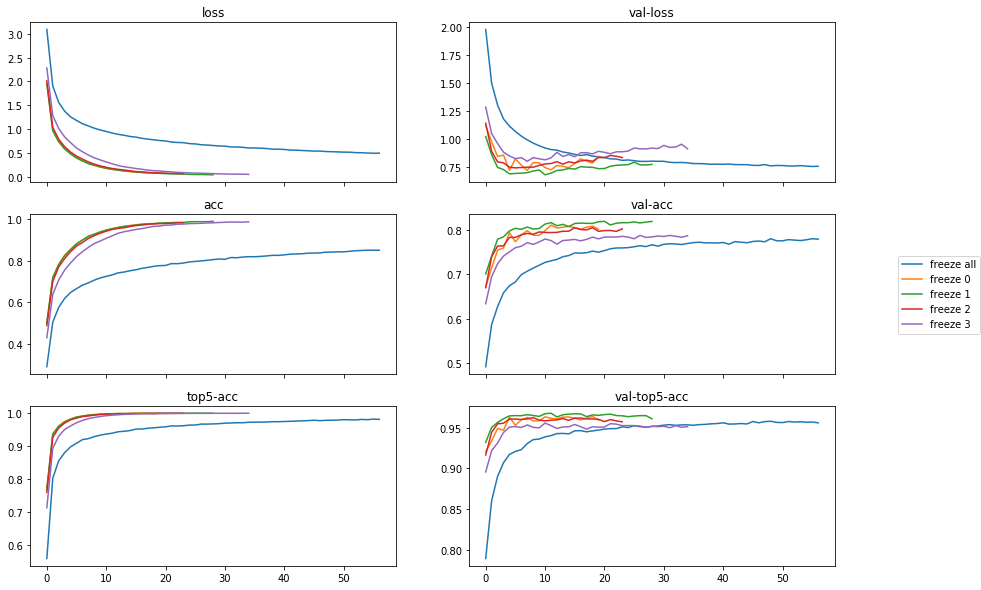

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

lines, labels = [], []
for config_name in histories:
    history = histories[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['acc'])
    ax[1, 1].plot(history.history['val_acc'])
    ax[2, 0].plot(history.history['top5_acc'])
    line = ax[2, 1].plot(history.history['val_top5_acc'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.87)

While most of our fine-tuned _ResNet-50_ instances are converging as fast in terms of training losses/metrics, we can observe some strong discrepancies regarding the validation results. We can directly observe that for this experiment on _CIFAR-100_, freezing the first macro-block only in the ImageNet-trained feature-extractor leads to the highes validation accuracy. It seems like models with the model instances with more frozen blocks may be slightly **over-fitting** the training sets (since they perform as well on the training data, but worse on the validation set).

Indeed, this experiment is a **typical example of the first transfer learning case** we introduced in Chapter 4 (c.f. book). _CIFAR-100_ is a rather small dataset, and its content can be seen as a subset of the _ImageNet_ dataset the Keras official models were trained on. However, the _CIFAR_ images are much lower quality ($32 \times 32$px only), so frozen feature extractors may have trouble recognizing downscaled higher-level features...

There is another interesting observation we can make from the results above. If we compare the accuracy of the _ResNet-50_ model we completely fine-tuned ("_freeze 0_") to the accuracy of the exact same model we trained from scratch in a [previous notebook](./ch4_nb2_reuse_models_from_keras_apps.ipynb), the difference is quite clear. By **instantiating our networks with pre-trained weights instead of random ones**, we boosted the performance of our model (c.f. Chapter 4 - the boost is clear here, since the original and target tasks are quite similar).

***Note:*** In practice, **it is however common to train several instances of a model with different hyper-parameters**, in order to find the best configuration. It is a time-consuming and heavy task, but necessary when high performance is a key factor.

## Visual Results

For the sake of concluding Chapter 4 with some visual results, we will reuse the code introduced in a [previous notebook](./ch4_nb1_implement_resnet_from_scratch.ipynb), to display some predictions on the test data:

ResNet-50 trained on ImageNet and fine-tuned on CIFAR-100:


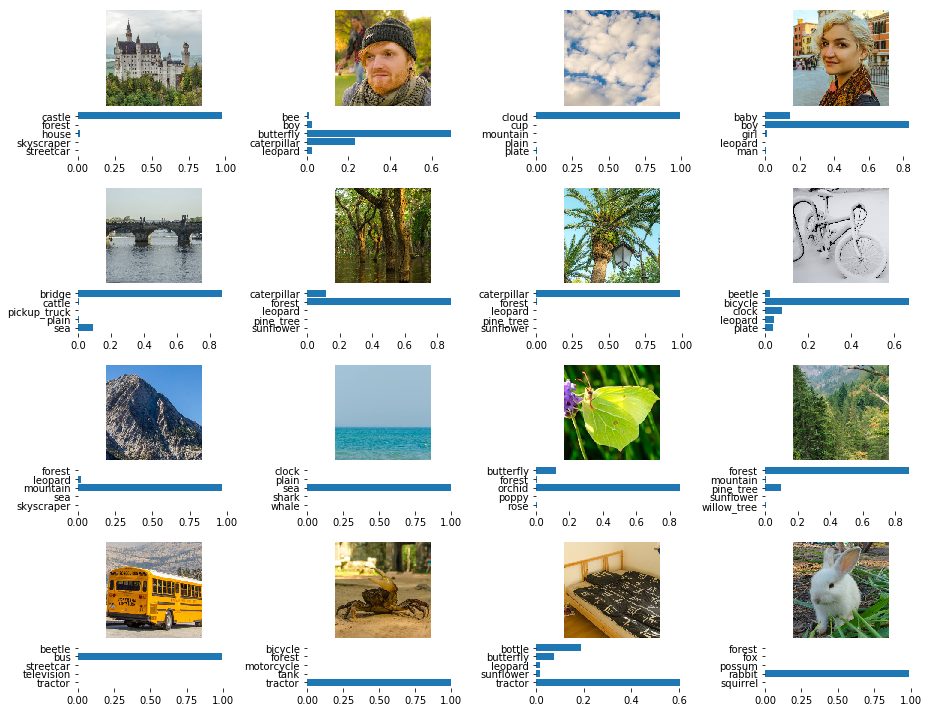

In [18]:
import glob
import numpy as np
from classification_utils import load_image, process_predictions, display_predictions

test_filenames = glob.glob(os.path.join('res', '*'))
test_images = np.asarray([load_image(file, size=input_shape[:2]) 
                          for file in test_filenames])

image_batch = test_images[:16]

# Our model was trained on CIFAR images, which originally are 32x32px. We scaled them up
# to 224x224px to train our model on, but this means the resulting images had important
# artifacts/low quality.
# To test on images of the same quality, we first resize them to 32x32px, then to the 
#expected input size (i.e., 224x224px):
cifar_original_image_size = cifar_info.features['image'].shape[:2]
class_readable_labels = cifar_info.features["label"].names

image_batch_low_quality = tf.image.resize(image_batch, cifar_original_image_size)
image_batch_low_quality = tf.image.resize(image_batch_low_quality, input_shape[:2])
    
predictions = resnet50_finetune.predict_on_batch(image_batch_low_quality)
top5_labels, top5_probabilities = process_predictions(predictions, class_readable_labels)

print("ResNet-50 trained on ImageNet and fine-tuned on CIFAR-100:")
display_predictions(image_batch, top5_labels, top5_probabilities)

## Conclusion

With this, we are virtually done with Chapter 4. Through these four notebooks, we experimented with some state-of-the-art CNNs, even re-implemented the ResNet architecture by ourselves, and finally harnested the power of transfer learning. With these tools, we are now well-equiped to solve complex classification problems.

In the next chapters, we will transfer this knowledge to various tasks, like [object detection](../ch5), [semantic segmentation](../ch6), etc.

***Note:*** An additional notebook is attached to Chapter 4, presenting _ImageNet_ and _Tiny-ImageNet_ for those who want to experiment on larger classification datasets.  

<a id="ref"></a>
#### References

1. Krizhevsky, Alex, Hinton, Geoffrey. "*Learning multiple layers of features from tiny images*" (2009), Citeseer.
2. He, K., Zhang, X., Ren, S., Sun, J., 2015. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs].
3. Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M., Berg, A.C., Fei-Fei, L., 2014. ImageNet Large Scale Visual Recognition Challenge. arXiv:1409.0575 [cs].